# CLOUDY grid reader

Once a grid of CLOUDY simulations has been run, it's useful to navigate through the output files to check for warnings and errors. This notebook assumes the output files (`.out`) are in subdirectories divided by type (PDR/XDR) and gas density (the `hden` parameter in CLOUDY)

In [1]:
# working directory
wd = '/media/phd/cloudy/ngmgrid/'

# libraries
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.style as style
from matplotlib.ticker import MaxNLocator
import seaborn as sns
from collections import Counter

# useful constants
c = 2.99792458e10 #cm/s
pc = 3.086e18 # cm
msun = 1.99e33 # g
lsun = 3.9e33 # erg/s
ry_ev = 13.605698 # eV in 1 Rydberg
ry_nm = 91.1270 # nm in 1 Rydberg
ry_hz = 3.2898e+15 # Hz in 1 Rydberg

# seaborn options
sns.set(rc={"figure.dpi":130, 'savefig.dpi':130})
sns.set_style('ticks')
sns.set_style({'xtick.direction': 'in', 'ytick.direction': 'in',
              'xtick.top': True, 'ytick.right': True})
sns.set_context("paper", rc={"font.size":14, 
                             "axes.titlesize":16, "axes.labelsize":16,
                             'xtick.labelsize':14, 'ytick.labelsize':14, 
                             'xtick.minor.size': 0, 'ytick.minor.size': 0})

# Table of contents <a class="anchor" id="toc"></a>

1. [Check the output from a single simulation](#single)
2. [Find the problems among the full grid](#grid)

## 1. Check the output from a single simulation <a class="anchor" id="single"></a>
[(back to the top)](#toc)

Let's take for example `pdr_h325_g600`, which means PDR with $\log(n_H) = 3.25$ and $\log(G_0) = 6$

In [29]:
# fill these 3 variables for your file
rad = 'pdr'
hden = 3.25
G0 = 6

# generating the filename
sub = rad + '_h' + ('%.2f' % hden).replace('.', '')
if rad == 'pdr': this = '_g' + ('%.2f' % G0).replace('.', '')
if rad == 'xdr': this = '_x' + ('%.2f' % FX).replace('.', '')
this = sub + '/' + sub + this
print(wd + this + '.out')

# open the file
with open(wd + this + '.out', 'r') as f:
    lines = f.readlines()

/media/phd/cloudy/hagrid/pdr_h325/pdr_h325_g600.out


The output file is long and divided in blocks. Its structure is described in the Hazy 2 document. Here is a list:

- Input commands from the input file, within a box of `*`
- Informations about the continuum that strikes the illuminated face of the cloud (block with `CellPeak`)
- The chemical composition of the cloud (`Chemical Composition`)
- Disasters (`DISASTER`), problems (`PROBLEM`) and notes (`NOTE`)
- A summary of the conditions in the first zone (starts with `####  1`) and the last (starts with `###`)
- `Calculation stopped because`, the reason and the iteration number
- Warnings (`W-`), cautions (`C-`), surprises (`!`) and notes (no symbol)
- Final printout: it prints again the input commands, followed by predicted line intensities (`line intensities`), energy budget (`ENERGY BUDGET`), and average temperatures, densities, etc (`Averaged Quantities`)


It prints the last 4 points for every iteration (which starts with `Start Iteration `), then after the last iteration it prints:

- Column densities of some atoms, molecules and ions (`column densities`)
- Mean ionization and temperatures, averaged over volume, area and radius (`Mean Ionisation`)
- Convergence statistics (`Convergence statistics`)
- Final report, which lists the number of zones, iterations, warnings, cautions, execution time and if the calculation was succesful (`Cloudy exited OK`)

### Print disasters, problems, warnings, cautions and final report

In [30]:
for l in lines:
    
    # keep track of the iteration
    if 'Start Iteration' in l: print('-' * 50, '\n\n', l)
    
    # print every disaster, problem and notes
    if 'DISASTER' in l: print(l)
    if 'PROBLEM' in l: print(l)
    if 'NOTE' in l: print(l)
    
    # print every warning and caution
    if 'W-' in l: print(l)
    if 'C-' in l: print(l)
    
    # print final report
    if 'Cloudy ends' in l: print('*' * 50, '\n\n', l)
    if 'Stop in cdMain' in l: print(l)

 NOTE Setcon: continuum has zero intensity starting at  1.0052e+01 Ryd.

 C-Continuum zero at some energies.

-------------------------------------------------- 

           Start Iteration Number 2                                                                      PDR grid

 W-Calculation stopped because default number of zones reached.  Was this intended???

 W-Default limit can be increased while retaining this check with the SET NEND command.

 C-Continuum zero at some energies.

-------------------------------------------------- 

           Start Iteration Number 3                                                                      PDR grid

 C-Continuum zero at some energies.

 C-The Lya optical depth scale was overrun and this is the last iteration - Tspin(21 cm) is not valid.

 C-Another iteration is needed for Tspin(21 cm) to be valid.  Use the ITERATE command.

************************************************** 

  Cloudy ends: 1391 zones, 3 iterations, 3 cautions. (singl

### Simulation with failures

Let's do it with a simulation which exited OK but with a failure

In [31]:
# open the file
with open(wd + 'xdr_h100/xdr_h100_x275.out', 'r') as f:
    lines = f.readlines()

# print interesting lines
for l in lines:
    
    # keep track of the iteration
    if 'Start Iteration' in l: print('-' * 50, '\n\n', l)
    
    # print every disaster, problem and notes
    if 'DISASTER' in l: print(l)
    if 'PROBLEM' in l: print(l)
    if 'NOTE' in l: print(l)
    
    # print every warning and caution
    if 'W-' in l: print(l)
    if 'C-' in l: print(l)
    
    # print final report
    if 'Cloudy ends' in l: print('*' * 50, '\n\n', l)
    if 'Stop in cdMain' in l: print(l)

 PROBLEM  ConvFail 1, Temp not converged itr 1 zone 257 fnzone 258.41 Te=2.6308e+04 Htot=4.747e-21 Ctot=4.837e-21 rel err=-1.889e-02 rel tol:5.000e-03

 C-Model is thick to cosmic rays, which are on.

 C-A temperature discontinuity occurred from 8.77e+04K (zone 4) to 5.59e+05K (zone 5).

 C-An ionization jump occurred, elem H  1, by 6850% from 1.15e-03 (zone 256) to 2.10e-03 (zone 257) to 1.44e-01 (zone 258)

 C-An ionization jump occurred, elem He 1, by 2093% from 9.82e-03 (zone 256) to 2.58e-02 (zone 257) to 5.40e-01 (zone 258)

 C-An ionization jump occurred, elem Al 3, by 1661% from 1.40e-03 (zone 256) to 2.29e-03 (zone 257) to 3.81e-02 (zone 258)

 C-An ionization jump occurred, elem Si 2, by 8788% from 2.82e-03 (zone 256) to 7.12e-03 (zone 257) to 6.26e-01 (zone 258)

 C-An ionization jump occurred, elem S  3, by 1023% from 4.57e-02 (zone 256) to 7.74e-02 (zone 257) to 7.92e-01 (zone 258)

 C-An ionization jump occurred, elem S 17, by 1021% from 1.92e-02 (zone 3) to 2.00e-02 (zon

### A not OK simulation

Now a simulation which went wrong

In [3]:
# open the file
with open(wd + 'pdr_h575/pdr_h575_g400.out', 'r') as f:
    lines = f.readlines()

# print interesting lines
for l in lines:
    
    # keep track of the iteration
    if 'Start Iteration' in l: print('-' * 50, '\n\n', l)
    
    # print every disaster, problem and notes
    if 'DISASTER' in l: print(l)
    if 'PROBLEM' in l: print(l)
    if 'NOTE' in l: print(l)
    
    # print every warning and caution
    if 'W-' in l: print(l)
    if 'C-' in l: print(l)
    
    # print final report
    if 'Cloudy ends' in l: print('*' * 50, '\n\n', l)
    if 'Stop in cdMain' in l: print(l)

 NOTE Setcon: continuum has zero intensity starting at  1.0052e+01 Ryd.

 W-Calculation stopped because default number of zones reached.  Was this intended???

 W-Default limit can be increased while retaining this check with the SET NEND command.

 C-Continuum zero at some energies.

-------------------------------------------------- 

           Start Iteration Number 2                                                                      PDR grid

 W-Calculation stopped because default number of zones reached.  Was this intended???

 W-Default limit can be increased while retaining this check with the SET NEND command.

 C-Continuum zero at some energies.

 C-A temperature oscillation occurred by 39% from 1.21e+01 (zone 1388) to 8.71e+00 (zone 1389) to 1.23e+01 (zone 1390)

 C-An electron density oscillation occurred by 11% from 4.06e-02 (zone 1388) to 3.67e-02 (zone 1389) to 4.08e-02 (zone 1390)

 C-The temperature varied by 41.0% between two zones

---------------------------------

## 2. Find the problems among the full grid <a class="anchor" id="grid"></a>
[(back to the top)](#toc)

In [2]:
# generating the .out filelist
filelist = []
wd = '/media/phd/cloudy/ngmgrid/'
for subdir, dirs, files in os.walk(wd):
    filelist.append(files)
filelist = [item for sublist in filelist for item in sublist if '.out' in item and 'slurm' not in item]
len(filelist)

1058

The next block goes among the full grid and saves the errors in the list `report`, and the files showing those errors in the list `filrep`. The error to be saved can be selected with the variable list `condition`, the option should be `'W-', 'C-', '!', 'NOTE'` or a combination of those.

The logical variable `last_only` makes sure we are only saving the messages from the last iteration for every simulation. This is because many errors can be solved by CLOUDY with multiple iterations.

In [10]:
'''
These files have to be removed from the filelist, since
they miss the 'Cloudy ends' final part (i.e. the final report)
They have to be added MANUALLY to the swwlist.csv file
''';

#filelist.remove('pdr_h575_g125.out')
#filelist.remove('pdr_h575_g425.out')

In [6]:
### saved files lists

#oklist = list(set(filrep.copy())) # Cloudy exited OK
#swwlist = list(set(filrep.copy())) # something went wrong
#adplist = list(set(filrep.copy())) # ABORT DISASTER PROBLEM
# failist = list(set(filrep.copy())) # Failures
# problist = list(set(filrep.copy())) # PROBLEM
# convbaselist = list(set(filrep.copy())) # ConvBase
# crlist = list(set(filrep.copy())) # Model is thick to cosmic rays
# thflist = list(set(filrep.copy())) # C-This was probably due to a thermal front
# lyalist = list(set(filrep.copy())) # C-The Lya optical depth scale was overrun
# codenlist = list(set(filrep.copy())) # C-The CO density varied

In [7]:
flist = filelist
condition = ['something went wrong']
C_shorten = False
last_only = True
report = []
filrep = []
print('Looking for', condition, 'in', len(flist), 'files')
for filo in flist:
    with open(wd + '/' + '_'.join(filo.split('_', 2)[:2]) + '/' + filo, 'r') as f:
        lines = f.readlines()
        if last_only:
            n_iter = int(re.split('zones, |iteration', lines[-2])[1])
            if n_iter > 1: find_last = False
        else: find_last = True
        for l in lines:
            if ('Start Iteration Number ' + str(n_iter)) in l: find_last = True
            if find_last == True:
                if any(x in l for x in condition):
                    if C_shorten:
                        if 'occurred' in l: l = l.split('occurred')[0] + 'occurred'
                        elif 'varied' in l: l = l.split('varied')[0] + 'varied'
                    report.append(l)
                    filrep.append(filo)
print(len(set(report)), 'errors found, for a total of', len(report), 'times, in', len(set(filrep)), 'files')

Looking for ['something went wrong'] in 1056 files
1 errors found, for a total of 12 times, in 12 files


In [27]:
list(set(report))

[' PROBLEM DISASTER - the kinetic temperature appears to be below the lower limit of the code, 2.800e+00K.  It does not bracket thermal balance.\n']

In [8]:
list(set(filrep))

['pdr_h525_g400.out',
 'pdr_h500_g200.out',
 'pdr_h500_g225.out',
 'pdr_h550_g325.out',
 'pdr_h500_g100.out',
 'pdr_h550_g050.out',
 'pdr_h550_g300.out',
 'pdr_h475_g175.out',
 'pdr_h475_g350.out',
 'pdr_h475_g250.out',
 'pdr_h575_g050.out',
 'pdr_h525_g350.out']

Since we have the list of files with that error, we can check how those simulations ended

In [ ]:
for filo in filrep:
    with open(wd + '/' + '_'.join(filo.split('_', 2)[:2]) + '/' + filo, 'r') as f:
        print(filo, '\n', f.readlines()[-2], '\n')

We can also check the distribution in the parameters space ($n_H, G_0, F_X$) of the simulations that had that error (listed in `filerep`). In the next cell, firstly we extract the parameters from the files list, then we plot them

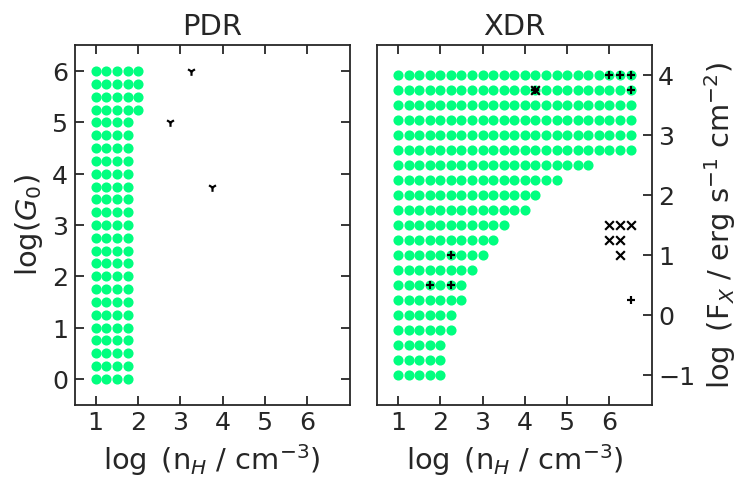

In [297]:
fig, (ax1, ax2) = plt.subplots(1, 2)

# first color
color = 'springgreen'
pdr_h, pdr_g, xdr_h, xdr_x = [], [], [], []
for f in crlist:
    fparts = f.split('_')
    hden = float(fparts[1].split('h')[1])/100
    if fparts[0] == 'pdr':
        pdr_h.append(hden)
        pdr_g.append(float(fparts[2][1:].split('.out')[0])/100)
    if fparts[0] == 'xdr':
        xdr_h.append(hden)
        xdr_x.append(float(fparts[2][1:].split('.out')[0])/100)

ax1.scatter(pdr_h, pdr_g, c=color)
ax2.scatter(xdr_h, xdr_x, c=color)

# second color
color, marker = 'black', 'x'
pdr_h, pdr_g, xdr_h, xdr_x = [], [], [], []
for f in thflist:
    fparts = f.split('_')
    hden = float(fparts[1].split('h')[1])/100
    if fparts[0] == 'pdr':
        pdr_h.append(hden)
        pdr_g.append(float(fparts[2][1:].split('.out')[0])/100)
    if fparts[0] == 'xdr':
        xdr_h.append(hden)
        xdr_x.append(float(fparts[2][1:].split('.out')[0])/100)

ax1.scatter(pdr_h, pdr_g, c=color, marker=marker)
ax2.scatter(xdr_h, xdr_x, c=color, marker=marker)

# third color
color, marker = 'black', '1'
pdr_h, pdr_g, xdr_h, xdr_x = [], [], [], []
for f in lyalist:
    fparts = f.split('_')
    hden = float(fparts[1].split('h')[1])/100
    if fparts[0] == 'pdr':
        pdr_h.append(hden)
        pdr_g.append(float(fparts[2][1:].split('.out')[0])/100)
    if fparts[0] == 'xdr':
        xdr_h.append(hden)
        xdr_x.append(float(fparts[2][1:].split('.out')[0])/100)

ax1.scatter(pdr_h, pdr_g, c=color, marker=marker)
ax2.scatter(xdr_h, xdr_x, c=color, marker=marker)

# fourth color
color, marker = 'black', '+'
pdr_h, pdr_g, xdr_h, xdr_x = [], [], [], []
for f in codenlist:
    fparts = f.split('_')
    hden = float(fparts[1].split('h')[1])/100
    if fparts[0] == 'pdr':
        pdr_h.append(hden)
        pdr_g.append(float(fparts[2][1:].split('.out')[0])/100)
    if fparts[0] == 'xdr':
        xdr_h.append(hden)
        xdr_x.append(float(fparts[2][1:].split('.out')[0])/100)

ax1.scatter(pdr_h, pdr_g, c=color, marker=marker)
ax2.scatter(xdr_h, xdr_x, c=color, marker=marker)

ax1.set_title('PDR')
ax1.set_ylim([-0.5, 6.5])
ax1.set_ylabel(r'$\log (G_0)$')
ax2.set_title('XDR')
ax2.set_ylim([-1.5, 4.5])
ax2.set_ylabel(r'$\log$ (F$_X$ / erg s$^{-1}$ cm$^{-2}$)')
ax2.yaxis.set_label_position('right')
ax2.yaxis.tick_right()
for ax in [ax1, ax2]:
    ax.set_xlim([0.5, 7])
    ax.set_xticks([1, 2, 3, 4, 5, 6])
    ax.set_xlabel(r'$\log$ (n$_H$ / cm$^{-3}$)')
fig.tight_layout()

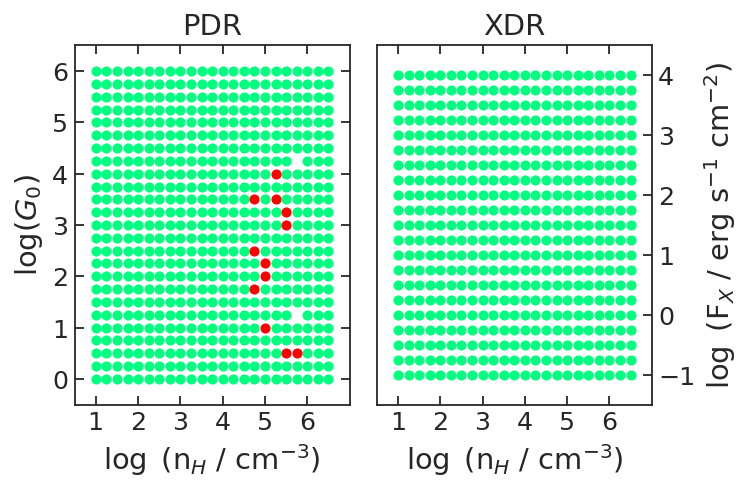

In [15]:
fig, (ax1, ax2) = plt.subplots(1, 2)

# first color
color = 'springgreen'
pdr_h, pdr_g, xdr_h, xdr_x = [], [], [], []
for f in oklist:
    fparts = f.split('_')
    hden = float(fparts[1].split('h')[1])/100
    if fparts[0] == 'pdr':
        pdr_h.append(hden)
        pdr_g.append(float(fparts[2][1:].split('.out')[0])/100)
    if fparts[0] == 'xdr':
        xdr_h.append(hden)
        xdr_x.append(float(fparts[2][1:].split('.out')[0])/100)

ax1.scatter(pdr_h, pdr_g, c=color)
ax2.scatter(xdr_h, xdr_x, c=color)

# second color
color, marker = 'red', 'o'
pdr_h, pdr_g, xdr_h, xdr_x = [], [], [], []
for f in swwlist:
    fparts = f.split('_')
    hden = float(fparts[1].split('h')[1])/100
    if fparts[0] == 'pdr':
        pdr_h.append(hden)
        pdr_g.append(float(fparts[2][1:].split('.out')[0])/100)
    if fparts[0] == 'xdr':
        xdr_h.append(hden)
        xdr_x.append(float(fparts[2][1:].split('.out')[0])/100)

ax1.scatter(pdr_h, pdr_g, c=color, marker=marker)
ax2.scatter(xdr_h, xdr_x, c=color, marker=marker)


ax1.set_title('PDR')
ax1.set_ylim([-0.5, 6.5])
ax1.set_ylabel(r'$\log (G_0)$')
ax2.set_title('XDR')
ax2.set_ylim([-1.5, 4.5])
ax2.set_ylabel(r'$\log$ (F$_X$ / erg s$^{-1}$ cm$^{-2}$)')
ax2.yaxis.set_label_position('right')
ax2.yaxis.tick_right()
for ax in [ax1, ax2]:
    ax.set_xlim([0.5, 7])
    ax.set_xticks([1, 2, 3, 4, 5, 6])
    ax.set_xlabel(r'$\log$ (n$_H$ / cm$^{-3}$)')
fig.tight_layout()